In [1]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, confusion_matrix, brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2
import shap

from boruta import BorutaPy

from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import pickle
from tqdm import tqdm

/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# divise le dataset en train et test suivant la proportion test_size voulue
# plus utilisée
def split_train_test(data, target, test_size):
    nb_samples = len(target)
    nb_test = int(test_size * nb_samples)

    shuffle = list(range(nb_samples))
    random.shuffle(shuffle)

    X_train, X_test, y_train, y_test = [], [], [], []
    
    nb_0 = 0
    nb_1 = 0

    for idx in shuffle:
        if nb_0 < (nb_test//2) and target[idx]==0:
            y_test.append(0)
            X_test.append(data[idx])
            nb_0 += 1
        elif nb_1 < (nb_test//2) and target[idx]==1:
            y_test.append(1)
            X_test.append(data[idx])
            nb_1 += 1
        else:
            y_train.append(target[idx])
            X_train.append(data[idx])
    
    return X_train, X_test, y_train, y_test

def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [3]:
# Fonction d'affichage de la matrice de confusion 
def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(7,7)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1.2)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues", vmin=0, vmax=100)
    # plt.savefig(filename,  bbox_inches='tight')

In [13]:
# crée les datasets des données agrégées
# Masking = False <-> on considère les valeurs manquantes imputées comme des vraies valeurs
def aggregateData(dataGroup, id_list, window_time, masking=True):

    dataPath_Mimic = "../Mimic/dataMimic/"
    dataPath_ECMO = "../dataECMO/"
    dataPath_Rea = "../dataRea/"
    
    if dataGroup == "dataMimic":
        dataPath = dataPath_Mimic
        finalDataPath = dataPath + "finalData/"
    elif dataGroup == "dataECMO":
        dataPath = dataPath_ECMO
        finalDataPath = dataPath + "finalData/"
    else:
        finalDataPath = dataPath_Rea + "finalData/" 

    patients_df_mimic = pd.read_csv(dataPath_Mimic + "ventiles1.csv")

    

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):

        if dataGroup == "dataVentiles":
            if int(encounterId) >= 30000000:
                finalDataPath = dataPath_Mimic + "finalData/"
                sapsii = patients_df_mimic.loc[patients_df_mimic["stay_id"]==int(encounterId), "saps_max"].iloc[0]
                logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
                igs_pred = np.exp(logit)/(1+np.exp(logit))
            else:
                finalDataPath = dataPath_Rea + "finalData/"
                igs_df = pd.read_parquet(finalDataPath + encounterId + "/IGS.parquet")
                if igs_df.size > 0:
                    sapsii = float(igs_df["igsTotal"].iloc[0])
                    logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
                    igs_pred = np.exp(logit)/(1+np.exp(logit))
                else:
                    igs_pred = 0.5
        elif dataGroup == "dataMimic":
            sapsii = patients_df_mimic.loc[patients_df_mimic["stay_id"]==int(encounterId), "saps_max"].iloc[0]
            logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
            igs_pred = np.exp(logit)/(1+np.exp(logit))
        else:
            igs_df = pd.read_parquet(finalDataPath + encounterId + "/IGS.parquet")
            if igs_df.size > 0:
                sapsii = float(igs_df["igsTotal"].iloc[0])
                logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
                igs_pred = np.exp(logit)/(1+np.exp(logit))
            else:
                igs_pred = 0.5


        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")
        
        data_patient = []

        if masking:
            df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)
        else:
            df_dynamic_masked = df_dynamic.iloc[:(window_time*24)]

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> FiO2
        # 9 --> Compliance 
        # 10 --> Dialyse

        # Scope uniquement
        # idx_variables_kept = [0,1,2,3,4,5,6]
        
        # + Données démographiques
        # idx_variables_kept = [0,1,2,3,4,5,6]
        
        # + Scope Etendu (+ FiO2 et Compliance)
        # idx_variables_kept = [0,1,2,3,4,5,6,8,9]
        
        # + Données DPI
        idx_variables_kept = [0,1,2,3,4,5,6,7,8,9,10]

        df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        df_dynamic = df_dynamic.iloc[:,idx_variables_kept]
        
        statics = list(df_static.to_numpy()[0])
        mean = df_dynamic_masked.mean().tolist()
        sd = df_dynamic_masked.std().tolist()
        median = df_dynamic_masked.median().tolist()
        maxi = df_dynamic_masked.max().tolist()
        mini = df_dynamic_masked.min().tolist()
        first = list(df_dynamic.to_numpy()[0,:])
        last = list(df_dynamic_masked.to_numpy()[window_time*24-1,:])
        skewness = df_dynamic_masked.skew().tolist()
        kurtosis = df_dynamic_masked.kurtosis().tolist()


        mean_last_12 = df_dynamic_masked.iloc[window_time*24-13:,:].mean().tolist()
        sd_last_12 = df_dynamic_masked.iloc[window_time*24-13:,:].std().tolist()
        maxi_last_12 = df_dynamic_masked.iloc[window_time*24-13:,:].max().tolist()
        mini_last_12 = df_dynamic_masked.iloc[window_time*24-13:,:].min().tolist()

        mean_last_24 = df_dynamic_masked.iloc[window_time*24-25:,:].mean().tolist()
        sd_last_24 = df_dynamic_masked.iloc[window_time*24-25:,:].std().tolist()
        maxi_last_24 = df_dynamic_masked.iloc[window_time*24-25:,:].max().tolist()
        mini_last_24 = df_dynamic_masked.iloc[window_time*24-25:,:].min().tolist()

        mean_last_48 = df_dynamic_masked.iloc[window_time*24-49:,:].mean().tolist()
        sd_last_48 = df_dynamic_masked.iloc[window_time*24-49:,:].std().tolist()
        maxi_last_48 = df_dynamic_masked.iloc[window_time*24-49:,:].max().tolist()
        mini_last_48 = df_dynamic_masked.iloc[window_time*24-49:,:].min().tolist()

        mean_last_72 = df_dynamic_masked.iloc[window_time*24-73:,:].mean().tolist()
        sd_last_72 = df_dynamic_masked.iloc[window_time*24-73:,:].std().tolist()
        maxi_last_72 = df_dynamic_masked.iloc[window_time*24-73:,:].max().tolist()
        mini_last_72 = df_dynamic_masked.iloc[window_time*24-73:,:].min().tolist()


        mean_first_12 = df_dynamic_masked.iloc[:12,:].mean().tolist()
        sd_first_12 = df_dynamic_masked.iloc[:12,:].std().tolist()
        maxi_first_12 = df_dynamic_masked.iloc[:12,:].max().tolist()
        mini_first_12 = df_dynamic_masked.iloc[:12,:].min().tolist()

        mean_first_24 = df_dynamic_masked.iloc[:24,:].mean().tolist()
        sd_first_24 = df_dynamic_masked.iloc[:24,:].std().tolist()
        maxi_first_24 = df_dynamic_masked.iloc[:24,:].max().tolist()
        mini_first_24 = df_dynamic_masked.iloc[:24,:].min().tolist()

        mean_first_48 = df_dynamic_masked.iloc[:48,:].mean().tolist()
        sd_first_48 = df_dynamic_masked.iloc[:48,:].std().tolist()
        maxi_first_48 = df_dynamic_masked.iloc[:48,:].max().tolist()
        mini_first_48 = df_dynamic_masked.iloc[:48,:].min().tolist()


        data_patient.extend(mean)
        data_patient.extend(sd)
        # data_patient.extend(median)
        data_patient.extend(maxi)
        data_patient.extend(mini)
        data_patient.extend(first)
        data_patient.extend(last)
        data_patient.extend(skewness)
        data_patient.extend(kurtosis)

        data_patient.extend(mean_first_12)
        data_patient.extend(sd_first_12)
        data_patient.extend(maxi_first_12)
        data_patient.extend(mini_first_12)

        data_patient.extend(mean_first_24)
        data_patient.extend(sd_first_24)
        data_patient.extend(maxi_first_24)
        data_patient.extend(mini_first_24)

        data_patient.extend(mean_first_48)
        data_patient.extend(sd_first_48)
        data_patient.extend(maxi_first_48)
        data_patient.extend(mini_first_48)

        data_patient.extend(mean_last_12)
        data_patient.extend(sd_last_12)
        data_patient.extend(maxi_last_12)
        data_patient.extend(mini_last_12)

        data_patient.extend(mean_last_24)
        data_patient.extend(sd_last_24)
        data_patient.extend(maxi_last_24)
        data_patient.extend(mini_last_24)

        data_patient.extend(mean_last_48)
        data_patient.extend(sd_last_48)
        data_patient.extend(maxi_last_48)
        data_patient.extend(mini_last_48)

        data_patient.extend(mean_last_72)
        data_patient.extend(sd_last_72)
        data_patient.extend(maxi_last_72)
        data_patient.extend(mini_last_72)
        
        data_patient.extend([igs_pred])
        data_patient.extend(statics[0:3])

        
        data.append(data_patient)
    
    return data

# Retourne la liste des encounterId des patients utilisable d'une base de données (utilisable si durée minimale d'hospitalisation est assez grande et si la proportion de valeurs manquantes est suffisamment faible)
def prepareDeathList(dataGroup, window_time, is_test_ECMO=False):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        
        patients_df = pd.read_csv(dataPath + "ventiles.csv")
        df_ventilation_start = pd.read_csv(dataPath + "ventiles1.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                if label_death:
                    target.append(1)
                else:
                    target.append(0)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24: #and percentageMissingValues < 40:
            if is_test_ECMO:
                if installation_date.year < 2020:
                    id_list.append(encounterId)
                
                    delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
                    if delai_sortie_deces <= 1:
                        target.append(1)
                    else:
                        target.append(0)
            else:
                id_list.append(encounterId)
                
                delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
                delai_installation_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_installation_deces"].to_numpy()[0]
                if delai_sortie_deces <= 1: #and delai_installation_deces <= 35:
                    target.append(1)
                else:
                    target.append(0)
    
    return target, id_list

target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = aggregateData("dataECMO", id_list_ECMO, window_time=5, masking=True)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO_Unmasked = aggregateData("dataECMO", id_list_ECMO, window_time=5, masking=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:03<00:00, 50.65it/s]

ECMO dataset size: 153 , num_deceased: 55


In [6]:
target_111, id_list_111 = prepareDeathList("dataRangueil", window_time=5)
print(f"Mimic dataset size: {len(target_111)} , num_deceased: {np.sum(target_111)}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 679/679 [00:01<00:00, 596.60it/s]

Mimic dataset size: 560 , num_deceased: 132


In [7]:
target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
data_Mimic = aggregateData("dataMimic", id_list_Mimic, window_time=5)

print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4140/4140 [00:39<00:00, 105.32it/s]

Mimic dataset size: 4140 , num_deceased: 1054


In [8]:
# target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
# data_Rangueil = aggregateData("dataRangueil", id_list_Rangueil, window_time=5)

# print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

In [9]:
# target_MR = target_Mimic + target_Rangueil
# id_list = id_list_Mimic + id_list_Rangueil

# data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

# print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

In [48]:
# Création de la courbe ROC pour l'IGS II pour Mimic

# dataPath = "../Mimic/dataMimic/" 
# patients_df = pd.read_csv(dataPath + "ventiles1.csv")
# target, id_list = prepareDeathList("dataMimic", 5)

# mean_fpr = np.linspace(0, 1, 100)
# tprs = []
# y_pred_proba = []
# y_pred = []
# y_true = []

# i = 0
# for stay_id in id_list:
#     sapsii = patients_df.loc[patients_df["stay_id"]==int(stay_id), "saps_max"].iloc[0]
#     # sapsii = int(patients_df.loc[patients_df["stay_id"]==stay_id, "saps_max"])
#     logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
#     pred = np.exp(logit)/(1+np.exp(logit))

#     y_pred_proba.append(pred)
#     y_pred.append(int(pred > 0.5))
#     y_true.append(target[i])
        
#     i += 1

# auroc_sapsii = roc_auc_score(y_true, y_pred_proba)

# fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
# tprs.append(np.interp(mean_fpr, fpr, tpr))
# tprs[-1][0] = 0.0  # Ensure the curve starts at (0,0)

# mean_tpr_sapsii = np.mean(tprs, axis=0)
# mean_tpr_sapsii[-1] = 1.0  # Ensure the curve ends at (1,1)

# list_to_save = [auroc_sapsii, mean_tpr_sapsii, y_pred_proba, y_true]

# saved_results_folder = "./saved_results_2/"
# saved_file_name = "sapsii_Mimic"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4265/4265 [00:05<00:00, 803.36it/s]


In [60]:
# Création de la courbe ROC pour l'IGS II pour les ECMO

# dataPath = "../dataECMO/" 
# patients_df = pd.read_parquet(dataPath + "patients.parquet")
# target, id_list = prepareDeathList("dataECMO", 5)

# mean_fpr = np.linspace(0, 1, 100)
# tprs = []
# y_pred_proba = []
# y_pred = []
# y_true = []

# i = 0
# for encounterId in id_list:
#     igs_df = pd.read_parquet(dataPath + "finalData/" + encounterId + "/IGS.parquet")
#     if igs_df.size > 0:
#         sapsii = float(igs_df["igsTotal"].iloc[0])
#         logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
#         pred = np.exp(logit)/(1+np.exp(logit))
        
#         # pred = [float(igs_str[20:][:-1].replace(",","."))/100 for igs_str in igs_df.iloc[:,1].to_numpy()][0]
    
#         y_pred_proba.append(pred)
#         y_pred.append(int(pred > 0.5))
#         y_true.append(target[i])
            
#     i += 1

# auroc_sapsii = roc_auc_score(y_true, y_pred_proba)

# fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
# tprs.append(np.interp(mean_fpr, fpr, tpr))
# tprs[-1][0] = 0.0  # Ensure the curve starts at (0,0)

# mean_tpr_sapsii = np.mean(tprs, axis=0)
# mean_tpr_sapsii[-1] = 1.0  # Ensure the curve ends at (1,1)

# list_to_save = [auroc_sapsii, mean_tpr_sapsii, y_pred_proba, y_true]

# saved_results_folder = "./saved_results_2/"
# saved_file_name = "sapsii_ECMO"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 541.68it/s]


In [ ]:
# Grid Search pour LGBM

# from sklearn.metrics import make_scorer, roc_auc_score

# clf = lgb.LGBMClassifier()

# x_train, y_train = data_ECMO, target_ECMO

# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(class_weights))

# param_grid = {
#     'num_leaves': [3, 10, 20],
#     'learning_rate': [0.05, 0.2, 0.3],
#     'feature_fraction': [0.75],
#     'class_weight': [class_weights]
# }

# scorer = make_scorer(roc_auc_score, needs_proba=True)
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1, verbose=2)

# grid_search.fit(x_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best AUROC score: ", grid_search.best_score_)

In [10]:
# Divise le dataset en train/test/validation, en K fold. Le fold de numéro test_fold est choisi comme le fold de test
def split_data_CV(data, target, K, test_activated, validation_activated, test_fold=-1):
    num_samples = len(target)
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,K-1)
        while val_fold == test_fold:
            val_fold = random.randint(0,K-1)
    else:
        val_fold = None
    
    x_train = np.empty((0, np.shape(data)[1]))
    y_train = []
    x_test = []
    y_test = []
    x_val = []
    y_val = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            x_train = np.concatenate((x_train, current_data_fold))
            y_train = y_train + current_target_fold

    return x_train, y_train, x_test, y_test, x_val, y_val

In [11]:
saveDataPath_Rangueil = "../final_datasets/Rangueil/without_imputation/"

test_target_Rangueil = np.load(saveDataPath_Rangueil + "test_target.npy")
test_ids_Rangueil = np.load(saveDataPath_Rangueil + "test_ids.npy")
train_target_Rangueil = np.load(saveDataPath_Rangueil + "train_target.npy")
train_ids_Rangueil = np.load(saveDataPath_Rangueil + "train_ids.npy")

train_data_Rangueil = aggregateData("dataRangueil", train_ids_Rangueil, window_time=5)
test_data_Rangueil = aggregateData("dataRangueil", test_ids_Rangueil, window_time=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 97.94it/s]


In [15]:
saveDataPath_ECMO = "../final_datasets/ECMO/without_imputation2/"

test_target_ECMO0 = np.load(saveDataPath_ECMO + "test_target.npy")
test_ids_ECMO0 = np.load(saveDataPath_ECMO + "test_ids.npy")
train_target_ECMO0 = np.load(saveDataPath_ECMO + "train_target.npy")
train_ids_ECMO0 = np.load(saveDataPath_ECMO + "train_ids.npy")

train_data_ECMO0 = aggregateData("dataECMO", train_ids_ECMO0, window_time=5, masking=False)
test_data_ECMO0 = aggregateData("dataECMO", test_ids_ECMO0, window_time=5, masking=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.79it/s]


In [16]:
saveDataPath_ECMO = "../final_datasets/ECMO/with_imputation2/"

test_target_ECMO1 = np.load(saveDataPath_ECMO + "test_target.npy")
test_ids_ECMO1 = np.load(saveDataPath_ECMO + "test_ids.npy")
train_target_ECMO1 = np.load(saveDataPath_ECMO + "train_target.npy")
train_ids_ECMO1 = np.load(saveDataPath_ECMO + "train_ids.npy")

train_data_ECMO1 = aggregateData("dataECMO", train_ids_ECMO1, window_time=5, masking=False)
test_data_ECMO1 = aggregateData("dataECMO", test_ids_ECMO1, window_time=5, masking=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.06it/s]


In [62]:
saveDataPath_Mimic = "../final_datasets/Mimic/without_imputation/"

test_target_Mimic0 = np.load(saveDataPath_Mimic + "test_target.npy")
test_ids_Mimic0 = np.load(saveDataPath_Mimic + "test_ids.npy")
train_target_Mimic0 = np.load(saveDataPath_Mimic + "train_target.npy")
train_ids_Mimic0 = np.load(saveDataPath_Mimic + "train_ids.npy")

train_data_Mimic0 = aggregateData("dataMimic", train_ids_Mimic0, window_time=5, masking=False)
test_data_Mimic0 = aggregateData("dataMimic", test_ids_Mimic0, window_time=5, masking=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:07<00:00, 56.98it/s]


In [15]:
saveDataPath_Mimic = "../final_datasets/Mimic/with_imputation/"

test_target_Mimic1 = np.load(saveDataPath_Mimic + "test_target.npy")
test_ids_Mimic1 = np.load(saveDataPath_Mimic + "test_ids.npy")
train_target_Mimic1 = np.load(saveDataPath_Mimic + "train_target.npy")
train_ids_Mimic1 = np.load(saveDataPath_Mimic + "train_ids.npy")

train_data_Mimic1 = aggregateData("dataMimic", train_ids_Mimic1, window_time=5, masking=False)
test_data_Mimic1 = aggregateData("dataMimic", test_ids_Mimic1, window_time=5, masking=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:03<00:00, 111.76it/s]


In [17]:
saveDataPath_Ventiles = "../final_datasets/Ventiles/without_imputation/"

test_target_Ventiles0 = np.load(saveDataPath_Ventiles + "test_target.npy")
test_ids_Ventiles0 = np.load(saveDataPath_Ventiles + "test_ids.npy")
train_target_Ventiles0 = np.load(saveDataPath_Ventiles + "train_target.npy")
train_ids_Ventiles0 = np.load(saveDataPath_Ventiles + "train_ids.npy")

train_data_Ventiles0 = aggregateData("dataVentiles", train_ids_Ventiles0, window_time=5, masking=False)
test_data_Ventiles0 = aggregateData("dataVentiles", test_ids_Ventiles0, window_time=5, masking=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.42it/s]


In [18]:
saveDataPath_Ventiles = "../final_datasets/Ventiles/with_imputation/"

test_target_Ventiles1 = np.load(saveDataPath_Ventiles + "test_target.npy")
test_ids_Ventiles1 = np.load(saveDataPath_Ventiles + "test_ids.npy")
train_target_Ventiles1 = np.load(saveDataPath_Ventiles + "train_target.npy")
train_ids_Ventiles1 = np.load(saveDataPath_Ventiles + "train_ids.npy")

train_data_Ventiles1 = aggregateData("dataVentiles", train_ids_Ventiles1, window_time=5, masking=False)
test_data_Ventiles1 = aggregateData("dataVentiles", test_ids_Ventiles1, window_time=5, masking=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.11it/s]


In [18]:
saveDataPath_ECMO_M = "../final_datasets/ECMO_M/"

target_ECMO_M = np.load(saveDataPath_ECMO_M + "target_ECMO_M.npy")
ids_ECMO_M = np.load(saveDataPath_ECMO_M + "ids_ECMO_M.npy")

data_ECMO_M = aggregateData("dataMimic", ids_ECMO_M, window_time=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 100.15it/s]


shape x_train : (122, 400)
shape x_test : (30, 400)


/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/delmaire.c/minicond

Mean AUROC: 0.543 ± 0.029
Mean Brier-Score: 0.330


/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


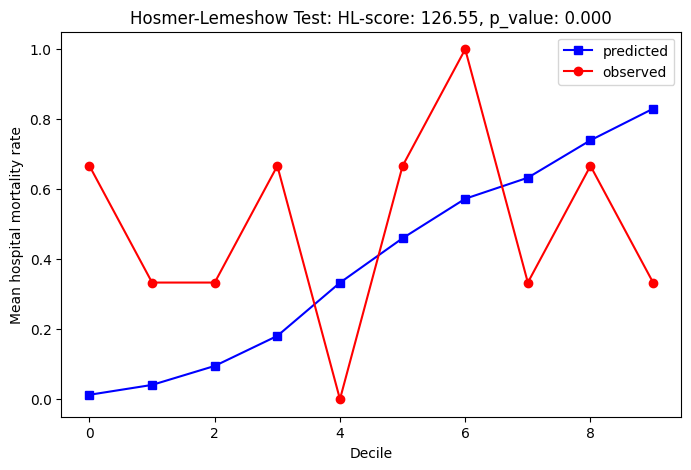

In [99]:
# Cellule principale

# Choix du dataset d'entraînement et de test en commentant les lignes ci-dessous

imputation = True

data = "ECMO"
# data = "mimic"
# data = "ventiles"

test = data
# test = "ECMO"


if data == "mimic":
    if test == data:
        if imputation:
            train_data = train_data_Mimic1
            train_target = train_target_Mimic1
            test_data = test_data_Mimic1
            test_target = test_target_Mimic1
        else:
            train_data = train_data_Mimic0
            train_target = train_target_Mimic0
            test_data = test_data_Mimic0
            test_target = test_target_Mimic0
    elif test == "ECMO":
        test_data = data_ECMO_Unmasked
        test_target = target_ECMO
        if imputation:
            train_data = np.concatenate((train_data_Mimic1, test_data_Mimic1))
            train_target = np.concatenate((train_target_Mimic1, test_target_Mimic1))
        else:
            train_data = np.concatenate((train_data_Mimic0, test_data_Mimic0))
            train_target = np.concatenate((train_target_Mimic0, test_target_Mimic0))
    
elif data == "ventiles":
    if test == data:
        if imputation:
            train_data = train_data_Ventiles1
            train_target = train_target_Ventiles1
            test_data = test_data_Ventiles1
            test_target = test_target_Ventiles1
        else:
            train_data = train_data_Ventiles0
            train_target = train_target_Ventiles0
            test_data = test_data_Ventiles0
            test_target = test_target_Ventiles0
    elif test == "ECMO":
        test_data = data_ECMO_Unmasked
        test_target = target_ECMO
        if imputation:
            train_data = np.concatenate((train_data_Ventiles1, test_data_Ventiles1))
            train_target = np.concatenate((train_target_Ventiles1, test_target_Ventiles1))
        else:
            train_data = np.concatenate((train_data_Ventiles0, test_data_Ventiles0))
            train_target = np.concatenate((train_target_Ventiles0, test_target_Ventiles0))

elif data == "ECMO":
    if imputation:
        train_data = train_data_ECMO1
        train_target = train_target_ECMO1
        test_data = test_data_ECMO1
        test_target = test_target_ECMO1
    else:
        train_data = train_data_ECMO0
        train_target = train_target_ECMO0
        test_data = test_data_ECMO0
        test_target = test_target_ECMO0


# train_data = np.array(train_data)[:,top_features_indices]
# test_data = np.array(test_data)[:,top_features_indices]

print(f"shape x_train : {np.shape(train_data)}")
print(f"shape x_test : {np.shape(test_data)}")

aurocs = []
brier_scores = []
features_importance = np.zeros(len(train_data[0]))
shap_values_list = []
x_test_concatenation = np.empty((0,np.shape(test_data)[1]))

num_trains = 100
for i in range(num_trains):
    # for j in range(K):
    
    x_train, y_train, x_test, y_test, x_val, y_val = train_data, train_target, test_data, test_target, [], []
    # x_train, y_train, x_test, y_test, x_val, y_val = split_data_CV(data_Mimic, target_Mimic, 10, test_activated=True, validation_activated=False, test_fold=0)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    params = {
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'num_leaves': 15,
            'learning_rate': 0.1,
            'feature_fraction': 0.45,
            'n_estimators':100,
            'class_weight': class_weights,
            'verbose': -1,
            'seed': random.randint(0,1000)
            }

    clf = lgb.LGBMClassifier(**params)

    # params = {
    #     'objective': 'binary:logistic',
    #     'eval_metric': 'auc',
    #     'learning_rate': 0.06,
    #     'max_depth': 10,
    #     'verbosity': 0,
    #     'n_estimator': 100,
    #     'seed': random.randint(0,1000)
    # }

    # clf = xgb.XGBClassifier(**params)
    
    # clf = LogisticRegression(solver='sag', penalty='l2', verbose=0, max_iter=1000, class_weight=class_weights)
    
    clf.fit(x_train, y_train)
    
    # y_pred_train = clf.predict_proba(x_train)[:, 1]
    # iso_reg = IsotonicRegression(out_of_bounds='clip')
    # y_iso = iso_reg.fit_transform(y_pred_train, y_train)
    
    fold_importances = clf.feature_importances_
    features_importance += fold_importances

    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(np.array(x_test))
    x_test_concatenation = np.concatenate((x_test_concatenation,np.array(x_test)), axis=0)
    
    shap_values_list.append(shap_values)
    
    y_pred_test = clf.predict_proba(x_test)[:, 1]
    
    # y_pred_test_iso = iso_reg.transform(y_pred_test)

    auroc = roc_auc_score(y_test, y_pred_test)
    brier_scores = brier_score_loss(y_test, y_pred_test)
    # print(auroc)

    aurocs.append(auroc)

print(f"Mean AUROC: {np.mean(aurocs):.3f} ± {np.std(aurocs):.3f}")
print(f"Mean Brier-Score: {np.mean(brier_scores):.3f}")

predictions_list = y_pred_test

deciles = np.percentile(predictions_list, np.arange(0, 101, 10))
decile_labels = pd.cut(predictions_list, bins=deciles, labels=False, include_lowest=True)

HL_num_groups = np.zeros(10)
HL_pred_groups = np.zeros(10)
HL_true_groups = np.zeros(10)

for k in range(len(predictions_list)):
    group = decile_labels[k]
    HL_num_groups[group] +=1
    HL_pred_groups[group] += predictions_list[k]
    if y_test[k] > 0.5:
        HL_true_groups[group] += 1
        
HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
HL_p_value = 1 - chi2.cdf(HL_score, df=8)

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

plt.xlabel('Decile')
plt.ylabel('Mean hospital mortality rate')
plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

plt.legend()

plt.show()

In [24]:
# Grid Search

imputation = True

# data = "ECMO"
# data = "mimic"
data = "ventiles"

test = data
# test = "ECMO"


if data == "mimic":
    if test == data:
        if imputation:
            train_data = train_data_Mimic1
            train_target = train_target_Mimic1
            test_data = test_data_Mimic1
            test_target = test_target_Mimic1
        else:
            train_data = train_data_Mimic0
            train_target = train_target_Mimic0
            test_data = test_data_Mimic0
            test_target = test_target_Mimic0
    elif test == "ECMO":
        test_data = data_ECMO
        test_target = target_ECMO
        if imputation:
            train_data = np.concatenate((train_data_Mimic1, test_data_Mimic1))
            train_target = np.concatenate((train_target_Mimic1, test_target_Mimic1))
        else:
            train_data = np.concatenate((train_data_Mimic0, test_data_Mimic0))
            train_target = np.concatenate((train_target_Mimic0, test_target_Mimic0))
    
elif data == "ventiles":
    if test == data:
        if imputation:
            train_data = train_data_Ventiles1
            train_target = train_target_Ventiles1
            test_data = test_data_Ventiles1
            test_target = test_target_Ventiles1
        else:
            train_data = train_data_Ventiles0
            train_target = train_target_Ventiles0
            test_data = test_data_Ventiles0
            test_target = test_target_Ventiles0
    elif test == "ECMO":
        test_data = data_ECMO
        test_target = target_ECMO
        if imputation:
            train_data = np.concatenate((train_data_Ventiles1, test_data_Ventiles1))
            train_target = np.concatenate((train_target_Ventiles1, test_target_Ventiles1))
        else:
            train_data = np.concatenate((train_data_Ventiles0, test_data_Ventiles0))
            train_target = np.concatenate((train_target_Ventiles0, test_target_Ventiles0))

elif data == "ECMO":
    if imputation:
        train_data = train_data_ECMO1
        train_target = train_target_ECMO1
        test_data = test_data_ECMO1
        test_target = test_target_ECMO1
    else:
        train_data = train_data_ECMO0
        train_target = train_target_ECMO0
        test_data = test_data_ECMO0
        test_target = test_target_ECMO0


# train_data = np.array(train_data)[:,top_features_indices]
# test_data = np.array(test_data)[:,top_features_indices]

print(f"shape x_train : {np.shape(train_data)}")
print(f"shape x_test : {np.shape(test_data)}")

aurocs = []

num_leaves_grid = [3,5,10,15,25,50]
learning_rate_grid = [0.01,0.03,0.1,0.3,1,3]
feature_fraction_grid = [0.03,0.1,0.3,0.5,1,2] 

aurocs = np.zeros((len(num_leaves_grid), len(learning_rate_grid), len(feature_fraction_grid)))

for i in range(len(num_leaves_grid)):
    for j in range(len(learning_rate_grid)):
        for k in range(len(feature_fraction_grid)):
            x_train, y_train, x_test, y_test, x_val, y_val = train_data, train_target, test_data, test_target, [], []
            
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            class_weights = dict(enumerate(class_weights))
            
            params = {
                    'objective': 'binary',
                    'metric': 'binary_error',
                    'boosting_type': 'gbdt',
                    'num_leaves': num_leaves_grid[i],
                    'learning_rate': learning_rate_grid[j],
                    'feature_fraction': 0.45,
                    'n_estimators':100,
                    'class_weight': class_weights,
                    'verbose': -1,
                    'seed': random.randint(0,1000)
                    }
        
            clf = lgb.LGBMClassifier(**params)
            
            clf.fit(x_train, y_train)
            
            y_pred_test = clf.predict_proba(x_test)[:, 1]
        
        
            auroc = roc_auc_score(y_test, y_pred_test)
        
            aurocs[i][j][k] = auroc

print(aurocs)

shape x_train : (4214, 401)
shape x_test : (468, 401)


KeyboardInterrupt: 

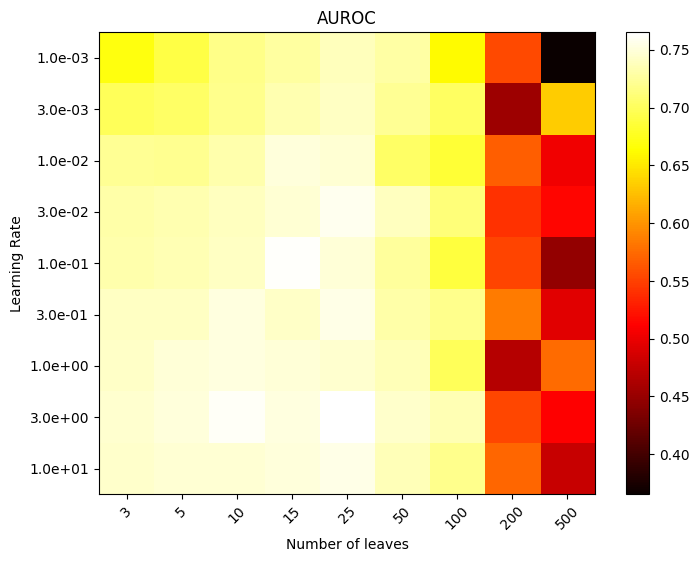

In [6]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(aurocs, interpolation='nearest', cmap='hot', aspect='auto')
# plt.grid(False)
plt.xlabel('Number of leaves')
plt.ylabel('Learning Rate')
plt.title('AUROC')

# # Log scale for axes
# plt.xscale('log')
# plt.yscale('log')

# Colorbar
plt.colorbar()

# Setting the ticks
plt.xticks(np.arange(len(num_leaves_grid)), labels=[f"{num_leaves}" for num_leaves in num_leaves_grid], rotation=45)
plt.yticks(np.arange(len(learning_rate_grid)), labels=[f"{lr:.1e}" for lr in learning_rate_grid])

plt.show()

In [12]:
import plotly.express as px

grid = []
for x in num_leaves_grid:
    for y in learning_rate_grid:
        for z in feature_fraction_grid:
            grid.append([x,y,z])

results = pd.DataFrame(data=np.array(grid), columns=["Number of leaves","Learning Rate","Feature Fraction"])
results["aurocs"] = aurocs.flatten()

fig = px.scatter_3d(results, x='Number of leaves', y='Learning Rate', z='Feature Fraction', color='aurocs')
fig.update_layout(
    title="Hyperparameter tuning",
    autosize=True, width=700, height=700,
    margin = dict(l=65, r=50, b=65, t=90))
fig.show()

0.13131313131313133
0.13131313131313133


/tmp/ipykernel_2405/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


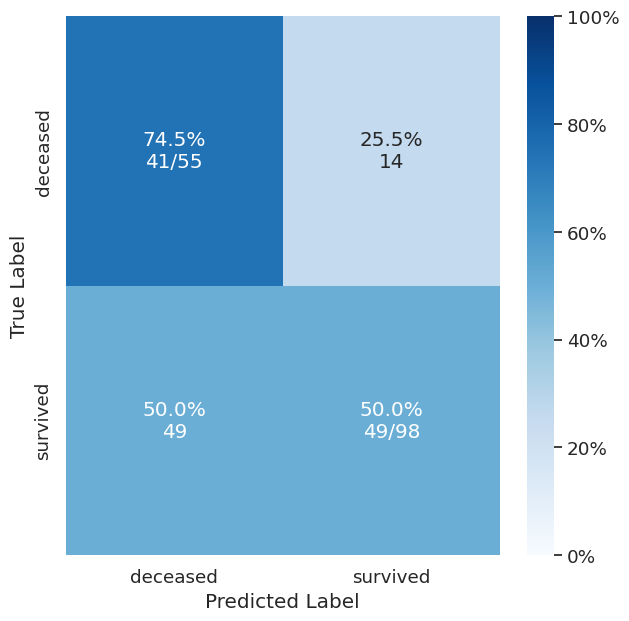

In [18]:
# Affichage d'une matrice de confusion

f1_scores = []
accuracies = []

thresholds = np.linspace(0,1,100)

predictions = clf.predict_proba(x_train)[:, 1]
true_labels = np.array(y_train)

for threshold in thresholds:
    predictions_binary = (predictions > threshold).astype(int)
    
    f1 = f1_score(true_labels, predictions_binary, zero_division=0)
    accuracy = accuracy_score(true_labels, predictions_binary)
    
    f1_scores.append(f1)
    accuracies.append(accuracy)
    
idx_best_threshold = np.array(f1_scores).argmax()
best_threshold_f1 = thresholds[idx_best_threshold]
idx_best_threshold = np.array(accuracies).argmax()
best_threshold_acc = thresholds[idx_best_threshold]

print(best_threshold_acc)
print(best_threshold_f1)

predictions_binary = y_pred_test > best_threshold_f1
cm_analysis(y_test, predictions_binary, [1,0], ["deceased","survived"])

/tmp/ipykernel_339337/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


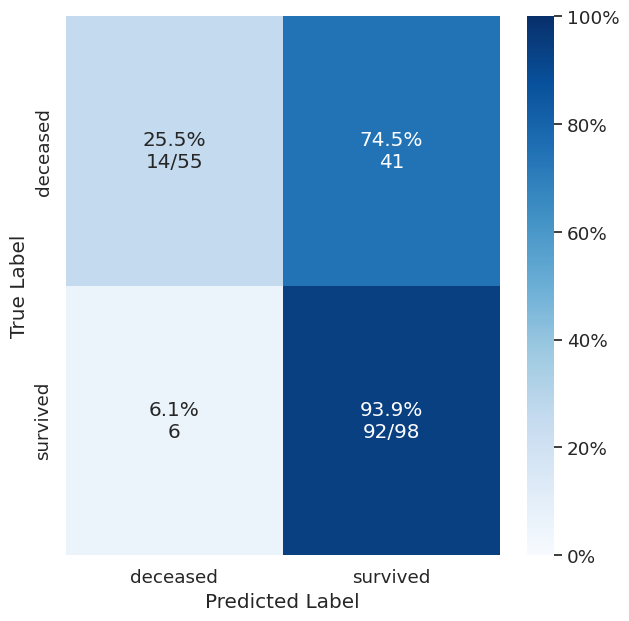

In [79]:
predictions_binary = y_pred_test > 0.4
cm_analysis(y_test, predictions_binary, [1,0], ["deceased","survived"])

AUROC on ECMO: 0.7460111317254174


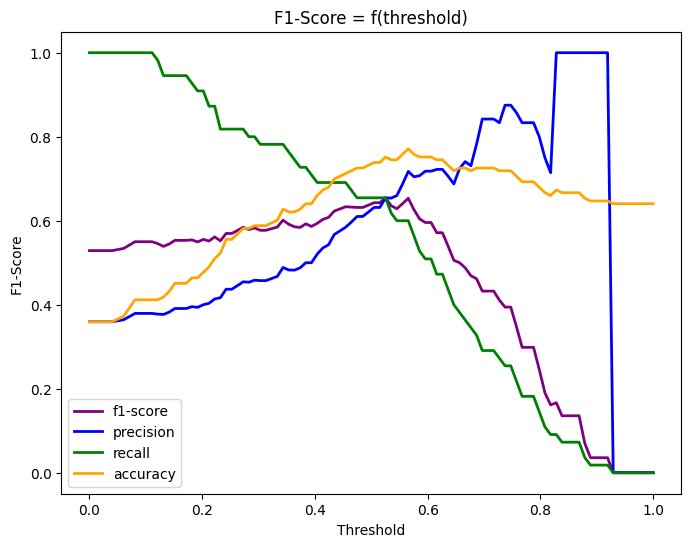

best threshold: 0.525
At best threshold: ACCURACY=0.752, PRECISION=0.655, RECALL=0.655, F1-SCORE=0.655


/tmp/ipykernel_339337/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


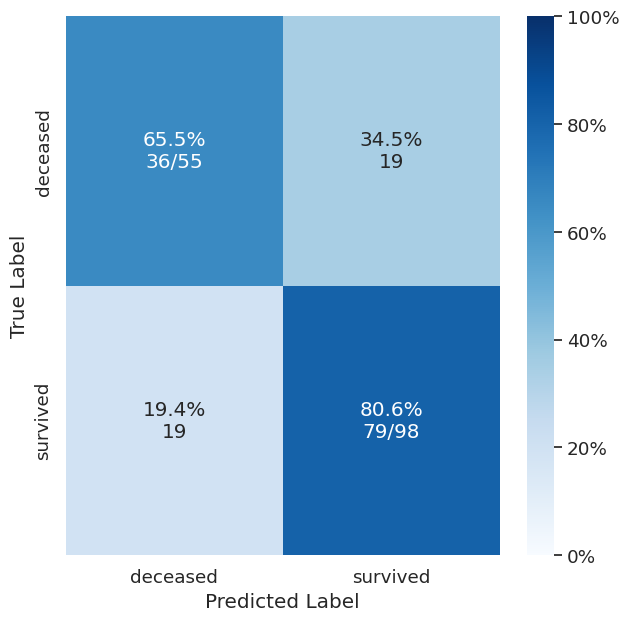

In [34]:
# data_ECMO_top_features = np.array(data_ECMO)[:,top_features_indices]
data_ECMO_top_features = np.array(data_ECMO)

predictions = clf.predict_proba(data_ECMO)[:, 1]
true_labels = target_ECMO

print(f"AUROC on ECMO: {roc_auc_score(true_labels, predictions)}")

f1_scores = []
precisions = []
recalls = []
accuracies = []

thresholds = np.linspace(0,1,100)

predictions = np.array(predictions).ravel()

for threshold in thresholds:
    predictions_binary = (predictions > threshold).astype(int)
    
    f1 = f1_score(true_labels, predictions_binary, zero_division=0)
    precision = precision_score(true_labels, predictions_binary, zero_division=0)
    recall = recall_score(true_labels, predictions_binary, zero_division=0)
    accuracy = accuracy_score(true_labels, predictions_binary) 
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    
plt.figure(figsize=(8, 6))

plt.plot(thresholds, f1_scores, lw=2, color='purple', label='f1-score')
plt.plot(thresholds, precisions, lw=2, color='blue', label='precision')
plt.plot(thresholds, recalls, lw=2, color='green', label='recall')
plt.plot(thresholds, accuracies, lw=2, color='orange', label='accuracy')


plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score = f(threshold)')
plt.legend()
plt.show()

idx_best_threshold = np.array(f1_scores).argmax()
best_threshold = thresholds[idx_best_threshold]
print(f"best threshold: {best_threshold:.3f}")
print(f"At best threshold: ACCURACY={accuracies[idx_best_threshold]:.3f}, PRECISION={precisions[idx_best_threshold]:.3f}, RECALL={recalls[idx_best_threshold]:.3f}, F1-SCORE={f1_scores[idx_best_threshold]:.3f}")

predictions_binary = predictions > best_threshold

cm_analysis(true_labels, predictions_binary, [1,0], ["deceased","survived"])

In [45]:
########### BORUTA #############

train_data = train_data_Ventiles1
train_target = train_target_Ventiles1
test_data = test_data_Ventiles1
test_target = test_target_Ventiles1

# train_data = train_data_Mimic
# train_target = train_target_Mimic
# test_data = test_data_Mimic
# test_target = test_target_Mimic


x_train, y_train, x_test, y_test, x_val, y_val = train_data, train_target, test_data, test_target, [], []
print(np.shape(x_train))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

clf = RandomForestClassifier(n_estimators=200, criterion='log_loss', n_jobs=-1, max_depth=25, class_weight=class_weights)
# clf.fit(x_train, y_train)
# y_pred_proba = clf.predict_proba(x_test)[:, 1]
# trans = BorutaPy(clf, random_state=42, verbose=2)
# sel = trans.fit_transform(np.array(x_train), np.array(y_train))

feat_selector = BorutaPy(clf, n_estimators='auto', verbose=2, random_state=None)
feat_selector.fit(np.array(x_train), np.array(y_train))

feat_selector.support_

rankings = feat_selector.ranking_
print(rankings)
# auroc = roc_auc_score(y_test, y_pred_proba)
# print(auroc)


(4214, 401)
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	401
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	96
Rejected: 	305
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	82
Rejected: 	305
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	82
Rejected: 	305
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	82
Rejected: 	305
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	68
Rejected: 	318
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	68
Rejected: 	318
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	68
Rejected: 	318
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	68
Rejected: 	318
Iteration: 	16 / 100
C

In [57]:
np.shape(top_features_indices)

(225,)

In [54]:
top_features_indices = np.where(rankings <= 200)[0]
top_features_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  14,  15,
        17,  18,  19,  20,  22,  25,  26,  28,  29,  37,  39,  40,  46,
        47,  48,  50,  55,  57,  58,  59,  60,  61,  62,  63,  65,  66,
        67,  68,  69,  70,  71,  74,  76,  79,  80,  82,  83,  85,  86,
        88,  89,  91,  92,  95,  96,  97,  99, 101, 104, 108, 109, 110,
       112, 121, 122, 129, 130, 132, 133, 139, 140, 141, 142, 143, 144,
       145, 148, 150, 151, 153, 154, 156, 161, 165, 166, 174, 176, 177,
       183, 184, 185, 186, 187, 188, 189, 192, 193, 194, 195, 198, 200,
       203, 208, 209, 210, 220, 221, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 235, 236, 238, 241, 242, 243, 244, 247, 249, 250,
       251, 253, 254, 255, 257, 261, 262, 263, 264, 265, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 282, 283,
       285, 286, 287, 291, 293, 294, 295, 298, 299, 301, 302, 304, 306,
       308, 309, 313, 314, 315, 316, 317, 318, 319, 320, 321, 32

(400,)


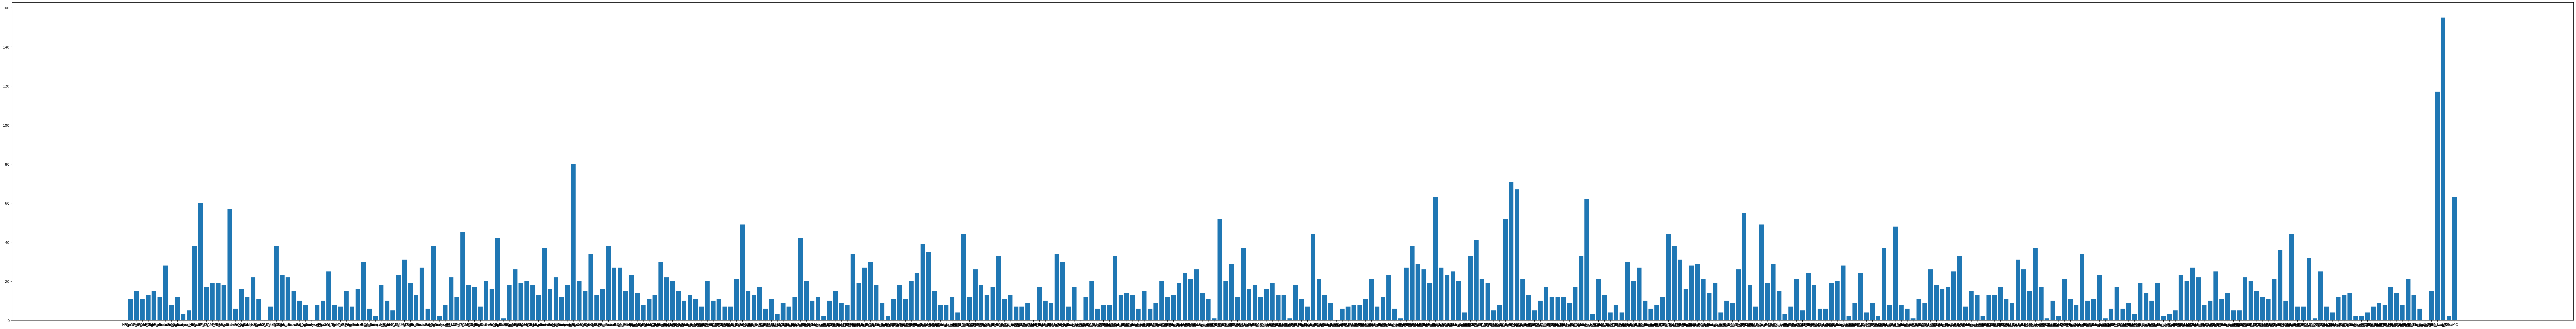

In [73]:
variables_str = ["HR", "SpO2", "PAD", "PAM", "PAS", "RR", "Temperature", "Diurese", "FiO2", "Compliance", "Dialyse"]
aggregations_str = ["mean", "sd", "maxi", "mini", "first", "last", "skewness", "kurtosis", "mean_first_12", "sd_first_12", "maxi_first_12", "mini_first_12", "mean_first_24", "sd_first_24", "maxi_first_24", "mini_first_24", "mean_first_48", "sd_first_48", "maxi_first_48", "mini_first_48", "mean_last_12", "sd_last_12", "maxi_last_12", "mini_last_12", "mean_last_24", "sd_last_24", "maxi_last_24", "mini_last_24", "mean_last_48", "sd_last_48", "maxi_last_48", "mini_last_48", "mean_last_72", "sd_last_72", "maxi_last_72", "mini_last_72"]
# aggregations_str = ["mean", "sd", "mini", "last"]
statics_str = ["igs", "age", "sexe", "IMC"]
# statics_str = ["age", "sexe", "IMC"]

features_str = []
for agg in aggregations_str:
    for var in variables_str:
        features_str.append(var + "_" + agg)
features_str += statics_str

print(np.shape(features_str))

values = features_importance

plt.figure(figsize=(128, 16))

plt.bar(features_str, values)

plt.show()

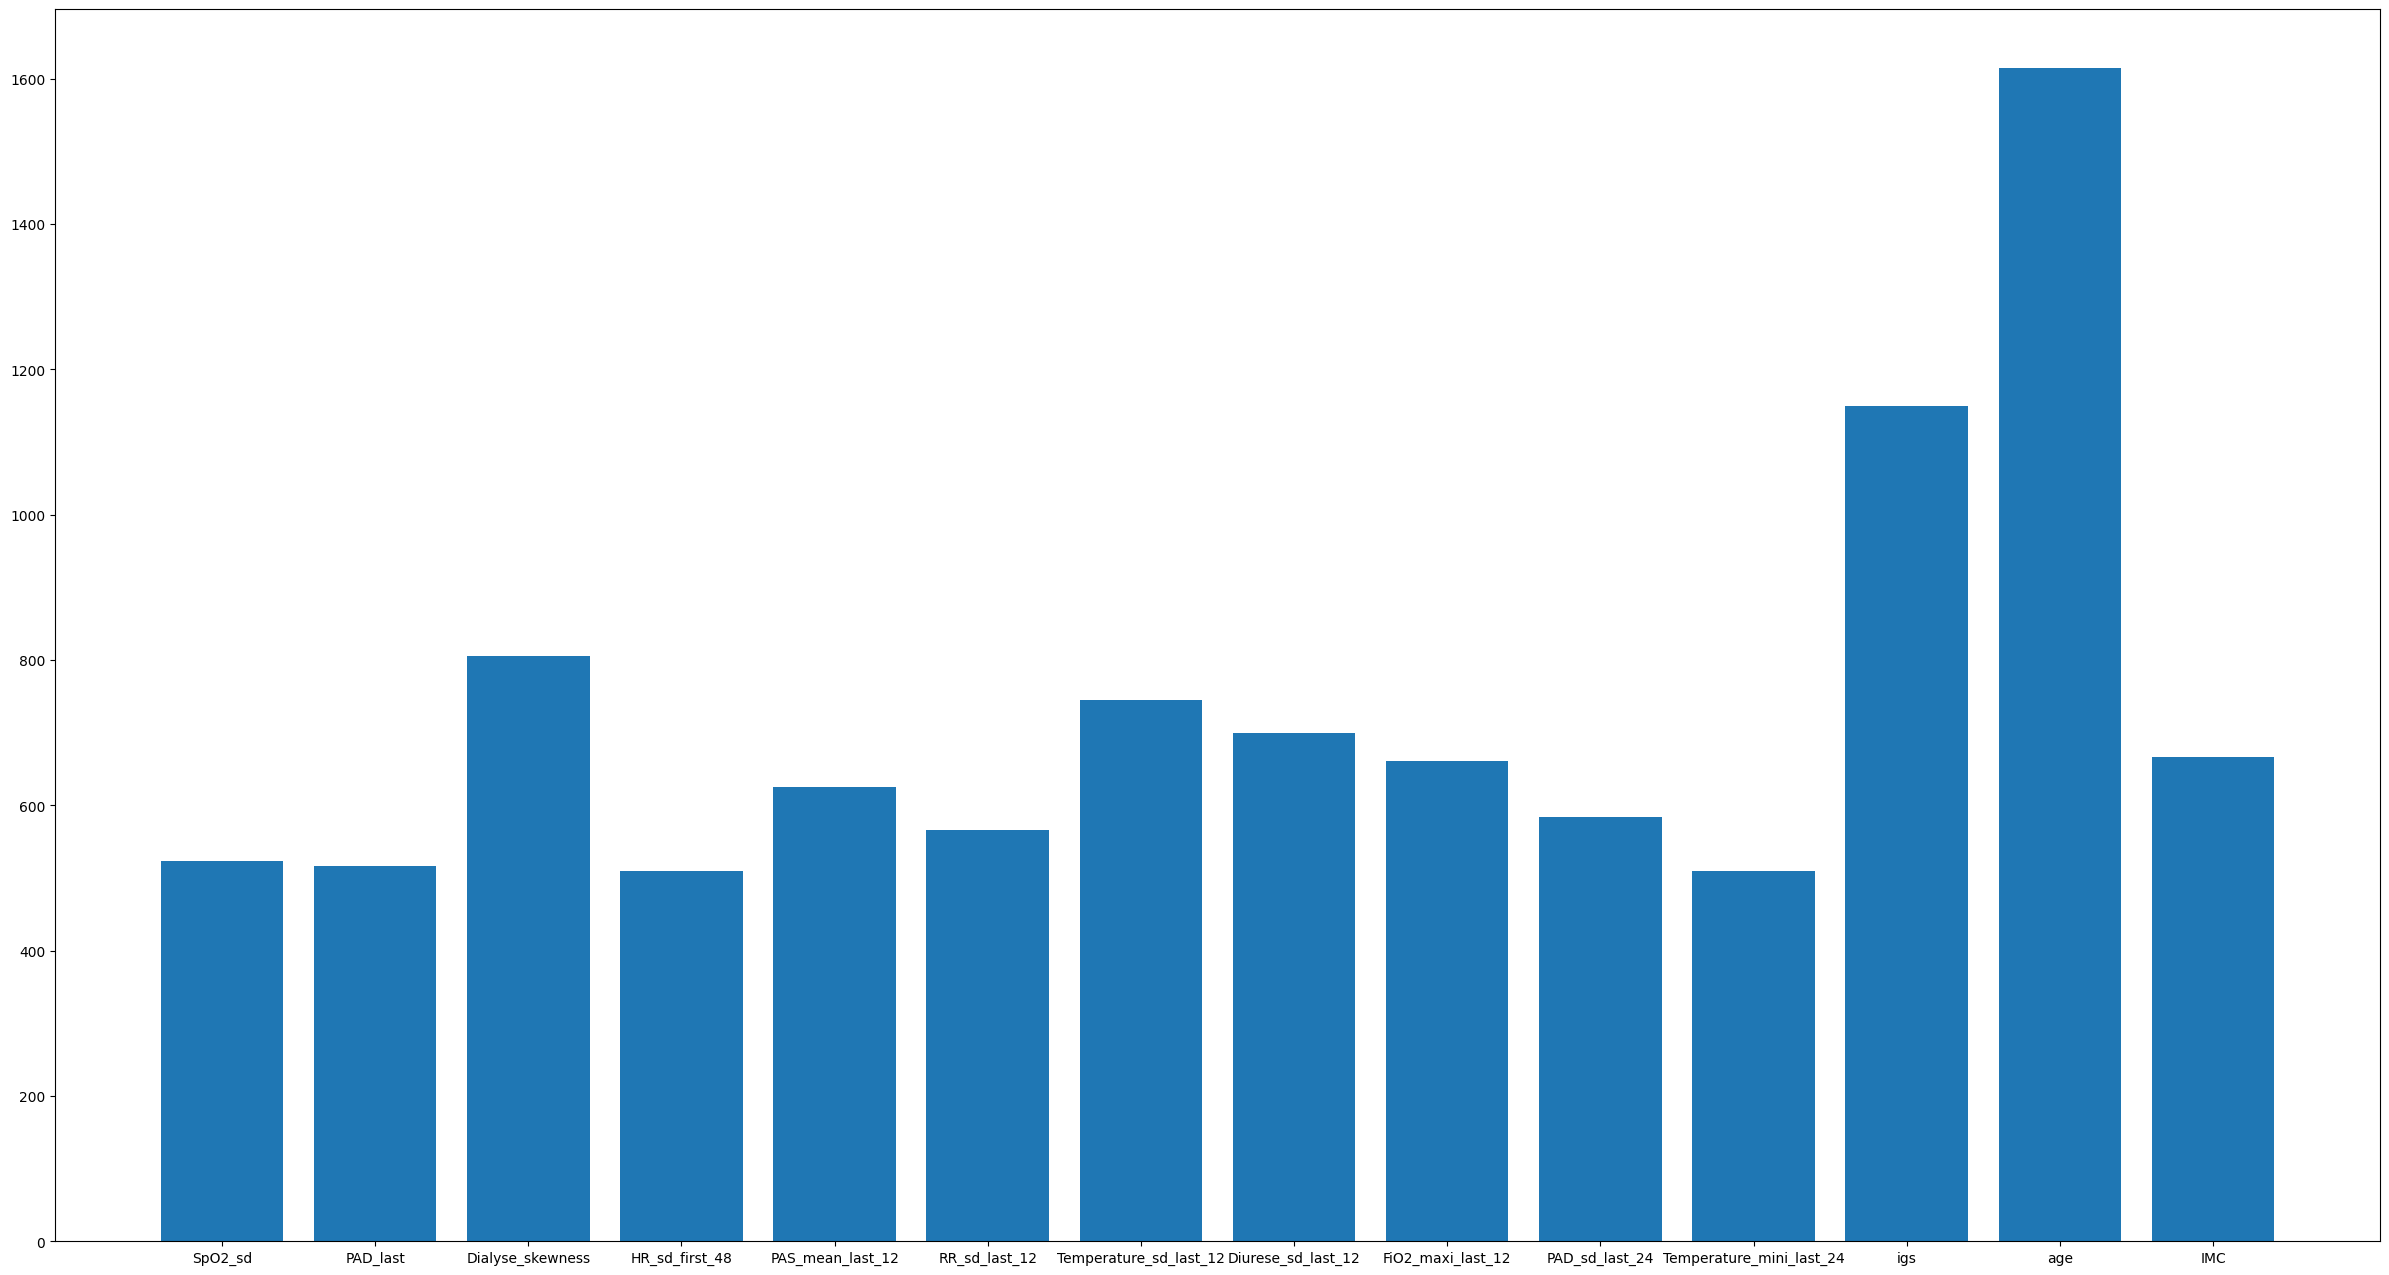

In [63]:
new_features_str = []
new_features_importance = []
for i in range(len(features_str)):
    if features_importance[i] > 500:
        new_features_str.append(features_str[i])
        new_features_importance.append(features_importance[i])

plt.figure(figsize=(30, 16))

plt.bar(new_features_str, new_features_importance)

plt.show()

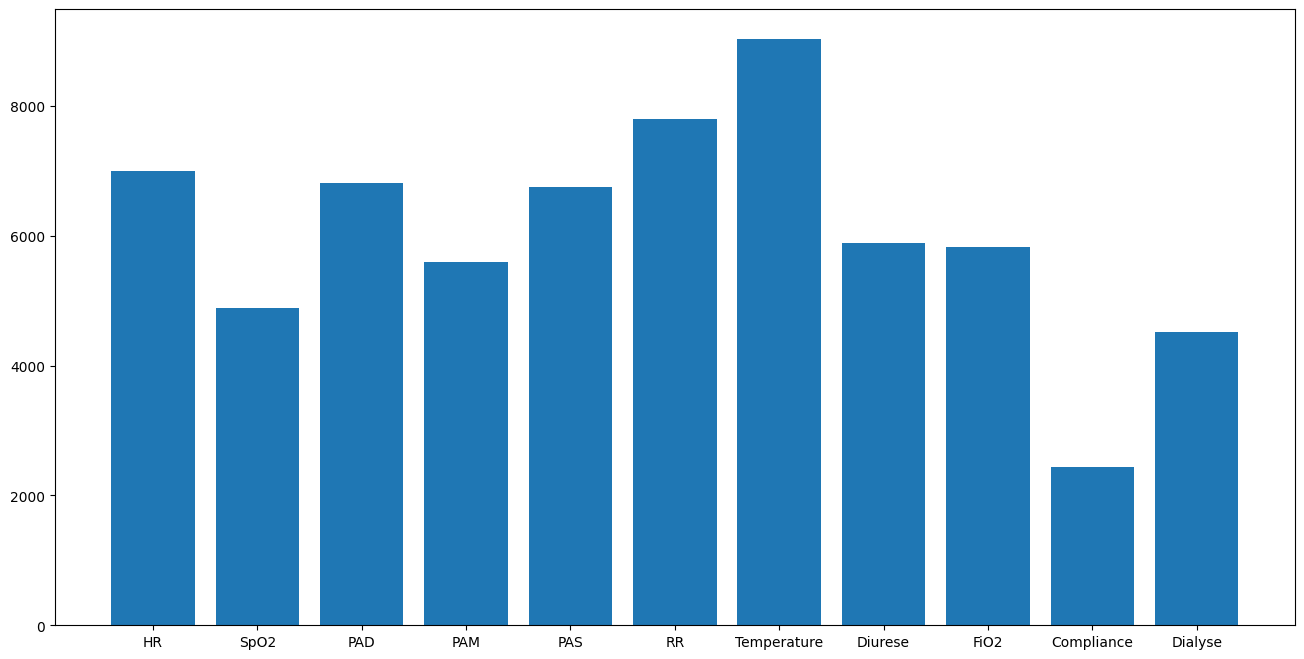

In [64]:
num_variables = len(variables_str)
num_aggregations = len(aggregations_str)

values_per_variable = np.zeros(num_variables)

for i in range(num_variables):
    for j in range(num_aggregations):
        values_per_variable[i] += values[i + j*num_variables]

plt.figure(figsize=(16, 8))

plt.bar(variables_str, values_per_variable)

plt.show()

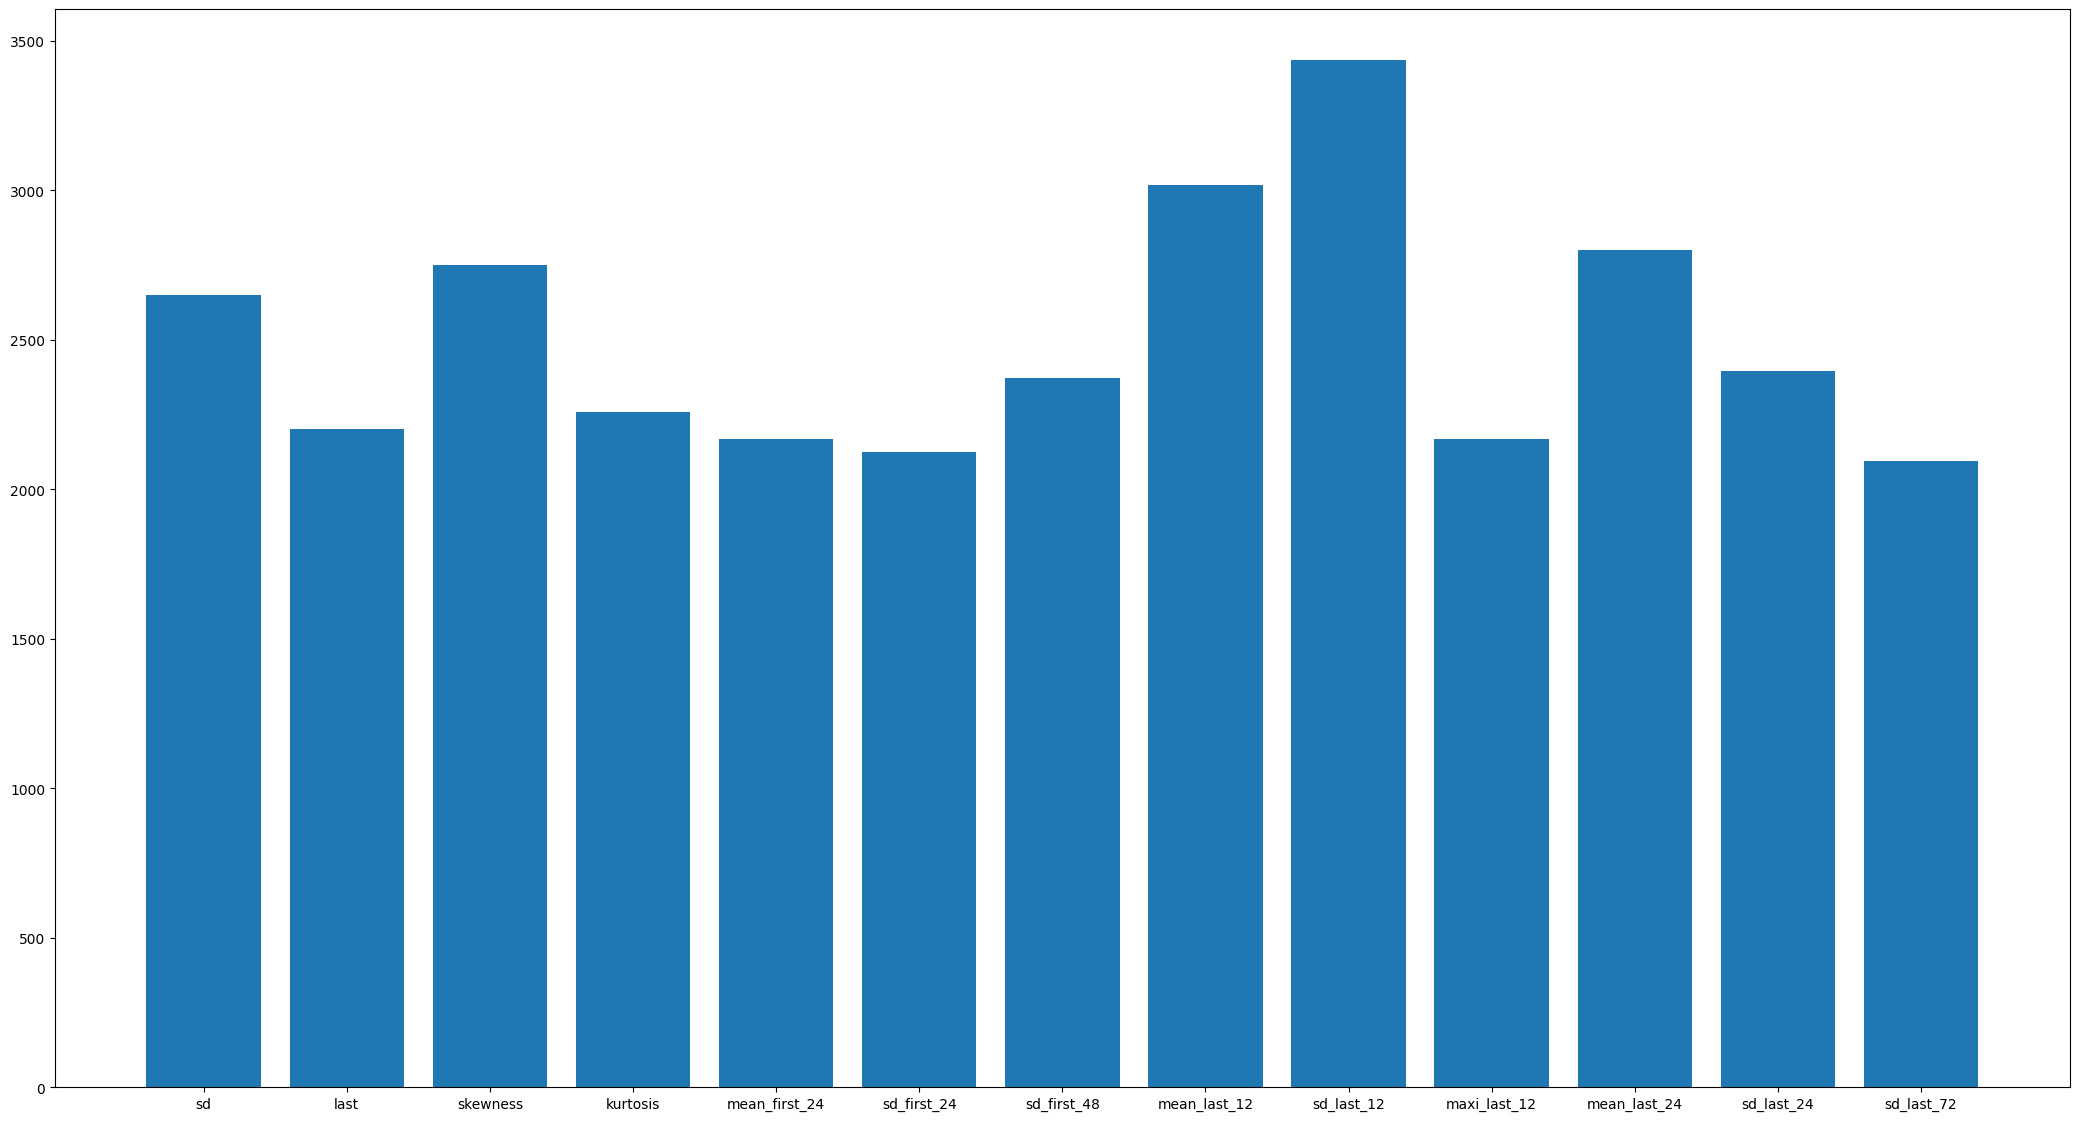

In [65]:
values_per_aggregation = np.zeros(num_aggregations)

for j in range(num_aggregations):
    for i in range(num_variables):
        values_per_aggregation[j] += values[i + j*num_variables]

best_aggregations = []
best_aggregations_str = []

for i in range(len(values_per_aggregation)):
    if values_per_aggregation[i] > 2000:
        best_aggregations.append(values_per_aggregation[i])
        best_aggregations_str.append(aggregations_str[i])

plt.figure(figsize=(26, 14))

plt.bar(best_aggregations_str, best_aggregations)

plt.show()

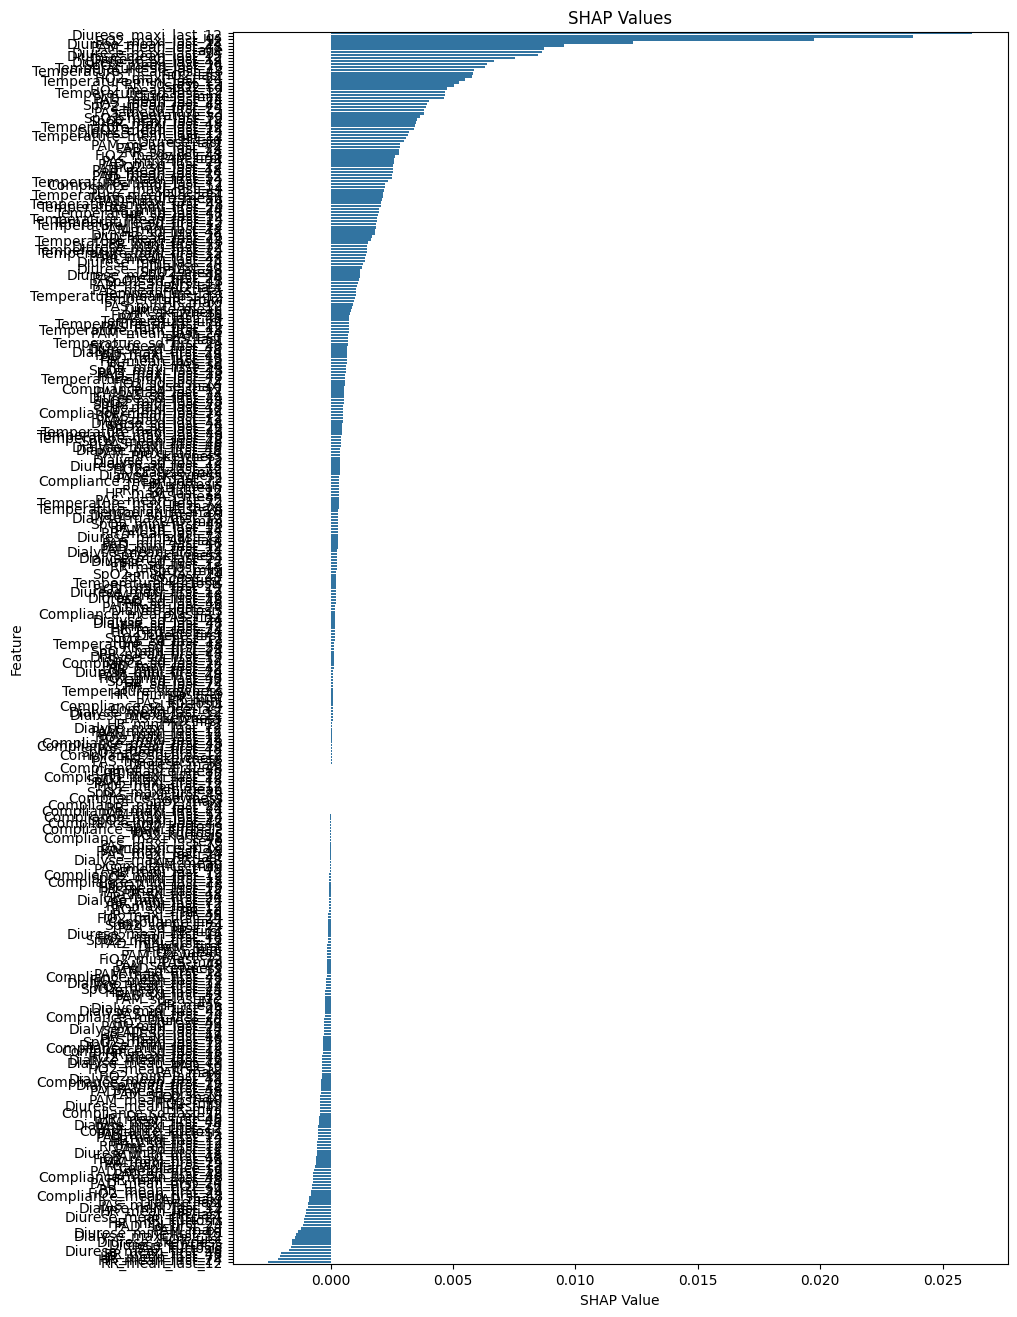

In [67]:
# Convertir la liste des valeurs SHAP en un tableau NumPy
all_shap_values = np.vstack(shap_values_list)

# Calculer la moyenne des valeurs SHAP pour chaque caractéristique
mean_shap_values = np.mean(all_shap_values, axis=0)
mean_shap_values_df = pd.DataFrame(mean_shap_values, index=features_str, columns=['mean_shap_value'])

# Trier les valeurs moyennées
mean_shap_values_df = mean_shap_values_df.sort_values(by='mean_shap_value', ascending=False)

plt.figure(figsize=(10, 16))
sns.barplot(x=mean_shap_values_df['mean_shap_value'], y=mean_shap_values_df.index)
plt.title('SHAP Values')
plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.show()

(3000, 400)
(3000, 400)


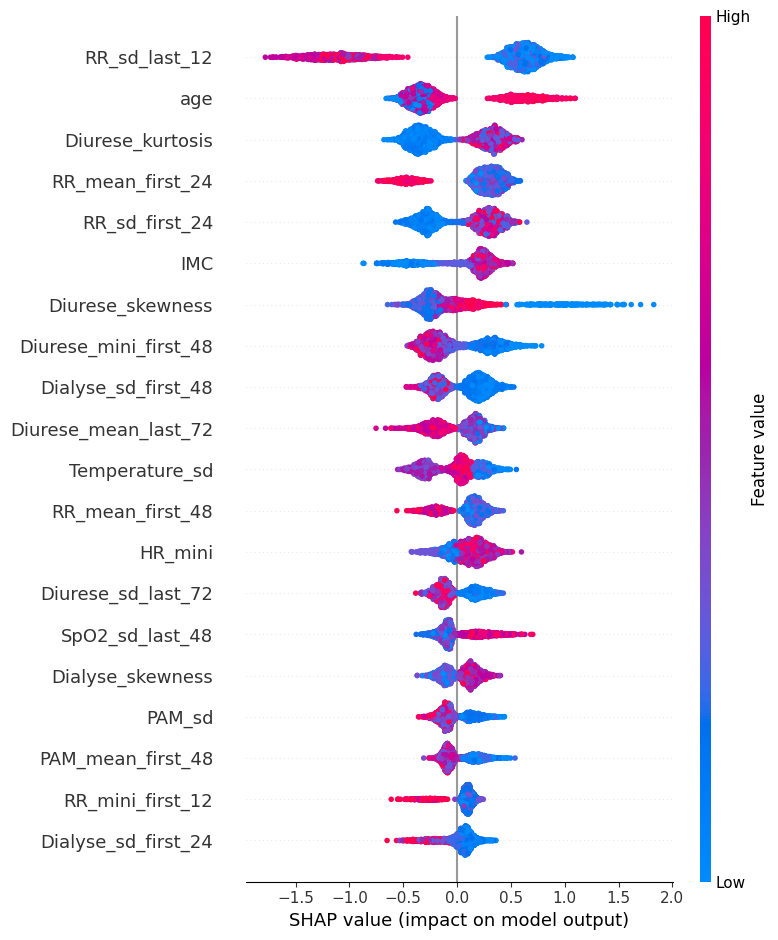

In [100]:
# Convertir la liste des valeurs SHAP en un tableau NumPy
all_shap_values = np.vstack(shap_values_list)

# Calculer la moyenne des valeurs SHAP pour chaque caractéristique
mean_shap_values = np.mean(all_shap_values, axis=0)

# Création d'un summary_plot avec les valeurs SHAP moyennées
dataForShap = pd.DataFrame(x_test_concatenation, columns=features_str)
print(all_shap_values.shape)
print(dataForShap.shape)
shap.summary_plot(all_shap_values, dataForShap)

In [232]:
# Test d'un MLP

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


train_data = train_data_Ventiles
train_target = train_target_Ventiles
test_data = test_data_Ventiles
test_target = test_target_Ventiles

# train_data = train_data_Mimic
# train_target = train_target_Mimic
# test_data = test_data_Mimic
# test_target = test_target_Mimic

train_data = np.array(train_data)[:,top_features_indices]
test_data = np.array(test_data)[:,top_features_indices]

print(np.shape(train_data))

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu')) 
model.add(Dense(16, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auroc')])

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

history = model.fit(train_data, train_target, epochs=15, batch_size=32, validation_split=0.2, class_weight=class_weights, verbose=1)


y_pred_proba = model.predict(test_data).flatten()
auroc = roc_auc_score(test_target, y_pred_proba)
print(auroc)

y_pred_proba = model.predict(np.array(data_ECMO_Unmasked)).flatten()
auroc = roc_auc_score(target_ECMO, y_pred_proba)
print(auroc)

(4214, 401)
Epoch 1/15


/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - auroc: 0.6412 - loss: 0.7481 - val_auroc: 0.6810 - val_loss: 0.7571
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - auroc: 0.7422 - loss: 0.6034 - val_auroc: 0.6679 - val_loss: 0.5675
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - auroc: 0.7841 - loss: 0.5620 - val_auroc: 0.6710 - val_loss: 0.5639
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - auroc: 0.7988 - loss: 0.5521 - val_auroc: 0.6668 - val_loss: 0.5537
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - auroc: 0.8325 - loss: 0.4987 - val_auroc: 0.6644 - val_loss: 0.6194
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - auroc: 0.8523 - loss: 0.4819 - val_auroc: 0.6685 - val_loss: 0.6030
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - auroc: 0.8681 - loss: 0.4599 - val_auroc: 0.6407 - val_loss: 0.5716
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - auroc: 0.8850 - loss: 0.4333 - val_auroc: 0.6569 - val_loss: 0.6526
Epoch 9/15
106/106 ━

0.2452929208360998


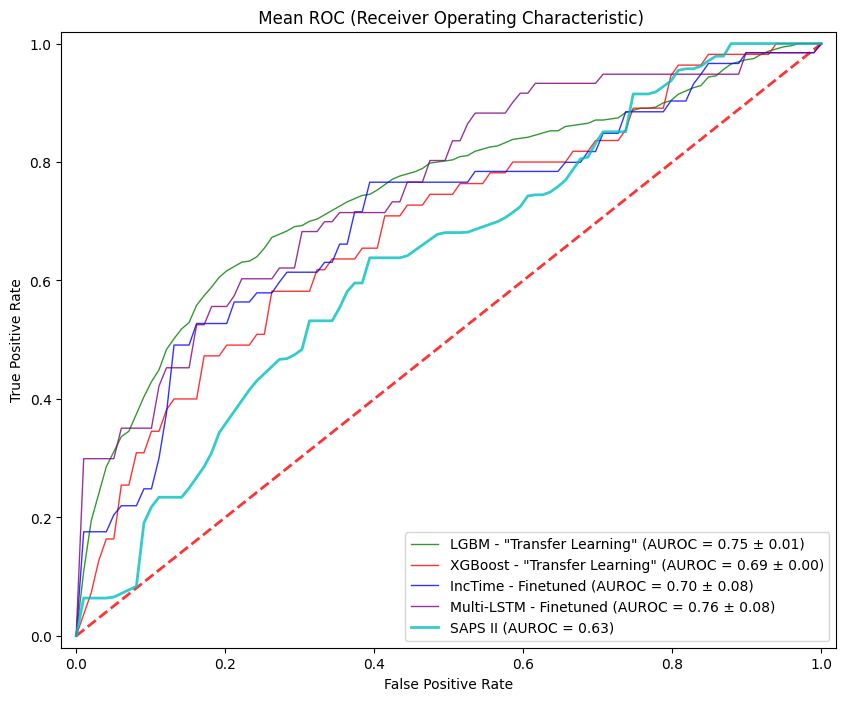

In [101]:
# Affichage de courbes ROC

saved_results_folder = "./saved_results_3/"

mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

# Plotting the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)


saved_file_name = "LGBM_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='green', 
         label=f'LGBM - "Transfer Learning" (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "XGB_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='red', 
         label=f'XGBoost - "Transfer Learning" (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "IncTime_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='blue', 
         label=f'IncTime - Finetuned (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "MLSTM_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='purple', 
         label=f'Multi-LSTM - Finetuned (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)

# print(brier_score_loss(list_result[3], list_result[2]))


saved_file_name = "sapsii_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

plt.plot(mean_fpr, mean_tpr, color='c', 
         label=f'SAPS II (AUROC = {aurocs:.2f})', 
         lw=2, alpha=0.8)


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Mean ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()